In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.pyplot import savefig
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

from datetime import datetime

import seaborn as sns
sns.set_style("ticks")
sns.set_context(context='paper',font_scale=1.2)
sns.despine()

from ehr_ml.clmbr import PatientTimelineDataset
from ehr_ml.timeline import TimelineReader

import yaml
import os
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import warnings
warnings.filterwarnings('ignore')

<Figure size 432x288 with 0 Axes>

In [2]:
# constant variables
cuda_device='cuda:4'
seed = 44
hparams_fpath = "/local-scratch/nigam/projects/jlemmon/cl-clmbr/experiments/main/hyperparams"
extract_path = '/local-scratch/nigam/projects/jlemmon/cl-clmbr/experiments/main/data/extracts/20210723'
model_path = '/local-scratch/nigam/projects/jlemmon/cl-clmbr/experiments/main/artifacts/models/clmbr/contrastive_learn/models'
cohort_fpath = "/local-scratch/nigam/projects/jlemmon/cl-clmbr/experiments/main/data/cohort"
pt_info_path = '/local-scratch/nigam/projects/jlemmon/cl-clmbr/experiments/main/artifacts/models/clmbr/pretrained/info/info.json'
labelled_path = "/local-scratch/nigam/projects/jlemmon/cl-clmbr/experiments/main/data/labelled_data"

dataset = pd.read_parquet(os.path.join(cohort_fpath, "cohort_split.parquet"))

In [3]:
tlr = TimelineReader(extract_path + '/extract.db', False)

In [4]:
def jaccard(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    if union == 0:
        return 0
    return float(intersection) / union

In [5]:
def load_data():
    """
    Load datasets from split csv files.
    """

    data_path = f'{labelled_path}/hospital_mortality/pretrained/gru_sz_800_do_0.1_cd_0_dd_0_lr_0.001_l2_0.01'


    train_pids = pd.read_csv(f'{data_path}/ehr_ml_patient_ids_train.csv')
  
    train_pids['pids'] = train_pids['0']

    train_days = pd.read_csv(f'{data_path}/day_indices_train.csv')
    train_days['days'] = train_days['0']

    #train_data = (train_labels.to_numpy().flatten(),train_pids.to_numpy().flatten(),train_days.to_numpy().flatten())

    return pd.concat((train_pids['pids'], train_days['days']),axis=1)

In [6]:
pid_day_df = load_data()

In [31]:
pat_info_df = pd.read_csv(f'{model_path}/gru_sz_800_do_0.1_cd_0_dd_0_lr_0.001_l2_0.01/bs_1000_lr_1e-5_temp_0.01_pool_rand_day/13/pat_info.csv')
tr_pred_df = pd.read_csv(f'{model_path}/gru_sz_800_do_0.1_cd_0_dd_0_lr_0.001_l2_0.01/bs_1000_lr_1e-5_temp_0.01_pool_rand_day/13/train_preds.csv')
pred_df = tr_pred_df.reset_index(drop=True)
pred_df['preds'] = (pred_df['preds'] - pred_df['preds'].min())/(pred_df['preds'].max() - pred_df['preds'].min())
v_pred_df = pd.read_csv(f'{model_path}/gru_sz_800_do_0.1_cd_0_dd_0_lr_0.001_l2_0.01/bs_1000_lr_1e-5_temp_0.01_pool_rand_day/13/val_preds.csv')

In [32]:
df = pred_df[['preds', 'labels']].groupby('labels').mean()
print('Mean prediction by label')
print(df)
df = pred_df[['preds', 'labels']].groupby('labels').median()
print('Median prediction by label')
print(df)
df = pred_df[['preds', 'labels']].groupby('labels').min()
print('Min prediction by label')
print(df)
df = pred_df[['preds', 'labels']].groupby('labels').max()
print('Max prediction by label')
print(df)

Mean prediction by label
           preds
labels          
0.0     0.228638
1.0     0.738184
Median prediction by label
           preds
labels          
0.0     0.223588
1.0     0.826029
Min prediction by label
           preds
labels          
0.0     0.000000
1.0     0.032169
Max prediction by label
        preds
labels       
0.0       1.0
1.0       1.0


[0.00000000e+00 2.41552006e-04 2.41552006e-04 ... 9.99958591e-01
 9.99958591e-01 1.00000000e+00]
[0.         0.0020302  0.00853141 ... 0.99998859 1.         1.        ]
[2.         1.         0.89990252 ... 0.03286755 0.03216918 0.        ]
35722
AUROC: 0.9402388804666413


Text(0, 0.5, 'TPR')

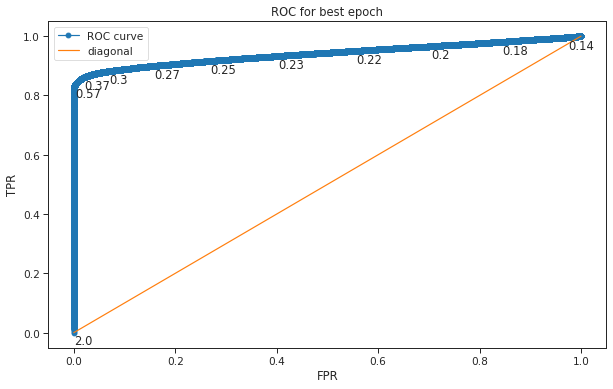

In [34]:
df = pred_df[['preds', 'labels']]

fpr, tpr, thresh = roc_curve(list(df['labels']), list(df['preds']))
print(fpr)
print(tpr)
print(thresh)
print(len(thresh))
print('AUROC:',roc_auc_score(list(df['labels']),list(df['preds'])))
plt.subplots(figsize=(10, 6))
plt.plot(fpr, tpr, 'o-', label="ROC curve")
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), label="diagonal")
for x, y, txt in zip(fpr[::3500], tpr[::3500], thresh[::3500]):
    plt.annotate(np.round(txt,2), (x, y-0.04))
plt.title(f'ROC for best epoch')
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')

In [35]:
df = pred_df[['preds', 'labels']].groupby('labels').median()
print('Median prediction by label')
print(df)
print('AUROC:',roc_auc_score(list(pred_df['labels']),list(pred_df['preds'])))
pred_df['adjust_labels'] = np.where(pred_df['preds'] > 0.5, 1, 0)
print('AUROC:',roc_auc_score(list(pred_df['adjust_labels']),list(pred_df['preds'])))
pat_df = pat_info_df.query('phase == "train"').reset_index(drop=True)

Median prediction by label
           preds
labels          
0.0     0.223588
1.0     0.826029
AUROC: 0.9402388804666413
AUROC: 1.0


In [36]:
pred_df[pred_df['labels'] != pred_df['adjust_labels']]

,epoch,preds,labels,adjust_labels
6,13,0.217113,1.0,0
72,13,0.375174,1.0,0
114,13,0.244998,1.0,0
126,13,0.245352,1.0,0
162,13,0.227415,1.0,0
...,...,...,...,...
521057,13,0.242527,1.0,0
521475,13,0.518445,0.0,1
521544,13,0.586454,0.0,1
521609,13,0.288891,1.0,0


In [28]:
ehr_pat_ids = list(tlr.get_patient_ids())
og_pat_ids = list(tlr.get_original_patient_ids())

In [29]:
num_pos = len(pred_df.query('labels==1'))
num_neg = len(pred_df.query('labels==0'))
tp = len(pred_df.query('labels==1 and adjust_labels==1'))
tn = len(pred_df.query('labels==0 and adjust_labels==0'))
fp = len(pred_df.query('labels==0 and adjust_labels==1'))
fn = len(pred_df.query('labels==1 and adjust_labels==0'))
print(f'TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}')
print(f'# +ve: {num_pos}, #-ve: {num_neg}')

TP: 73722, FP: 2084, TN: 432605, FN: 13954
# +ve: 87676, #-ve: 434689


In [17]:
fp_df = pred_df.query('labels==0 and adjust_labels==1')
fn_df = pred_df.query('labels==1 and adjust_labels==0')
tn_df = pred_df.query('labels==0 and adjust_labels==0').sample(n=2400)

In [18]:
pat_df.head()

,left_id,left_idx,left_max_idx,right_id,right_idx,right_max_idx,epoch,phase
0,1511399,54,126,1511399,54,126,8,train
1,1511399,54,126,184346,62,126,8,train
2,1511399,54,126,1409323,12,126,8,train
3,1511399,54,126,1409323,51,126,8,train
4,1511399,54,126,2447315,44,126,8,train


In [19]:
j_sim = []
pred_vals = []
age_diff = []
race_match = []
gender_match = []
day_diff = []
p1_num_code = []
p2_num_code = []


# look at overall patient codes for timeline


for i in range(len(fp_df)):
    p1_codeset = []
    p2_codeset = []
    fp_pred = fp_df['preds'].iloc[i]
    
    idx = fp_df.iloc[[i]].index.values[0]
    p1_id = pat_df['left_id'].loc[idx]
    p1_idx = pat_df['left_idx'].loc[idx]
    p1_max_idx = pat_df['left_max_idx'].loc[idx]
    p2_id = pat_df['right_id'].loc[idx]
    p2_idx = pat_df['right_idx'].loc[idx]
    p2_max_idx = pat_df['right_max_idx'].loc[idx]
    
    
    p1_id_day_df = pid_day_df.query('pids==@p1_id')
    p2_id_day_df = pid_day_df.query('pids==@p2_id')

    p1_og_id = og_pat_ids[ehr_pat_ids.index(p1_id)]
    p1_df = dataset.query('person_id==@p1_og_id')
    p2_og_id = og_pat_ids[ehr_pat_ids.index(p2_id)]
    p2_df = dataset.query('person_id==@p2_og_id')

    p1 = tlr.get_patient(p1_id)
    p2 = tlr.get_patient(p2_id)
    
    p1_days = list(p1.days)[:p1_max_idx]
    p2_days = list(p2.days)[:p2_max_idx]
    
    if p1_idx >= len(p1_days):
        print(p1_idx)
        print(len(p1_days))
        print(p1_max_idx)
        continue
    if p2_idx >= len(p2_days):
        print(p2_idx)
        print(len(p2_days))
        print(p2_max_idx)
        continue
    
    pred_vals.append(fp_pred)
    p1_day = p1_days[p1_idx]
    p2_day = p2_days[p2_idx]
    
    day_diff.append(np.abs(p1_id_day_df['days'].values[0]-p2_id_day_df['days'].values[0]))
    
    
    age_diff.append(np.abs(p1_day.age - p2_day.age)/365)
    
    if p1_df['race_eth'].unique()[0] == p2_df['race_eth'].unique()[0]:
        race_match.append(1)
    else:
        race_match.append(0)
    
    if p1_df['gender_concept_name'].unique()[0] == p2_df['gender_concept_name'].unique()[0]:
        gender_match.append(1)
    else:
        gender_match.append(0)
    
    p1_codes = []
    p2_codes = []
    
    for day in list(p1_days):
        p1_codes.extend(list(day.observations))
    for day in list(p2_days):
        p2_codes.extend(list(day.observations))
    
    p1_codes = list(set(p1_codes))
    p2_codes = list(set(p2_codes))
    j_sim.append(jaccard(p1_codes,p2_codes))
    p1_num_code.append(len(p1_codes))
    p2_num_code.append(len(p2_codes))

fp_comp_df = pd.DataFrame({'pred_val':pred_vals,'jaccard':j_sim, 'p1_num_code':p1_num_code, 'p2_num_code':p2_num_code, 'age_diff':age_diff, 'day_diff':day_diff, 'race_match':race_match, 'gender_match':gender_match})

In [20]:
j_sim = []
pred_vals = []
age_diff = []
race_match = []
gender_match = []
day_diff = []
p1_num_code = []
p2_num_code = []


# look at overall patient codes for timeline


for i in range(len(tn_df)):
    p1_codeset = []
    p2_codeset = []
    tn_pred = tn_df['preds'].iloc[i]
    
    idx = tn_df.iloc[[i]].index.values[0]
    p1_id = pat_df['left_id'].loc[idx]
    p1_idx = pat_df['left_idx'].loc[idx]
    p1_max_idx = pat_df['left_max_idx'].loc[idx]
    p2_id = pat_df['right_id'].loc[idx]
    p2_idx = pat_df['right_idx'].loc[idx]
    p2_max_idx = pat_df['right_max_idx'].loc[idx]
    
    
    p1_id_day_df = pid_day_df.query('pids==@p1_id')
    p2_id_day_df = pid_day_df.query('pids==@p2_id')

    p1_og_id = og_pat_ids[ehr_pat_ids.index(p1_id)]
    p1_df = dataset.query('person_id==@p1_og_id')
    p2_og_id = og_pat_ids[ehr_pat_ids.index(p2_id)]
    p2_df = dataset.query('person_id==@p2_og_id')

    p1 = tlr.get_patient(p1_id)
    p2 = tlr.get_patient(p2_id)
    
    p1_days = list(p1.days)[:p1_max_idx]
    p2_days = list(p2.days)[:p2_max_idx]
    
    if p1_idx >= len(p1_days):
        print(p1_idx)
        print(len(p1_days))
        print(p1_max_idx)
        continue
    if p2_idx >= len(p2_days):
        print(p2_idx)
        print(len(p2_days))
        print(p2_max_idx)
        continue
    
    pred_vals.append(fp_pred)
    p1_day = p1_days[p1_idx]
    p2_day = p2_days[p2_idx]
    
    day_diff.append(np.abs(p1_id_day_df['days'].values[0]-p2_id_day_df['days'].values[0]))
    
    
    age_diff.append(np.abs(p1_day.age - p2_day.age)/365)
    
    if p1_df['race_eth'].unique()[0] == p2_df['race_eth'].unique()[0]:
        race_match.append(1)
    else:
        race_match.append(0)
    
    if p1_df['gender_concept_name'].unique()[0] == p2_df['gender_concept_name'].unique()[0]:
        gender_match.append(1)
    else:
        gender_match.append(0)
    
    p1_codes = []
    p2_codes = []
    
    for day in list(p1_days):
        p1_codes.extend(list(day.observations))
    for day in list(p2_days):
        p2_codes.extend(list(day.observations))
    
    p1_codes = list(set(p1_codes))
    p2_codes = list(set(p2_codes))
    j_sim.append(jaccard(p1_codes,p2_codes))
    p1_num_code.append(len(p1_codes))
    p2_num_code.append(len(p2_codes))

tn_comp_df = pd.DataFrame({'pred_val':pred_vals,'jaccard':j_sim, 'p1_num_code':p1_num_code, 'p2_num_code':p2_num_code, 'age_diff':age_diff, 'day_diff':day_diff, 'race_match':race_match, 'gender_match':gender_match})

In [21]:
race_match_per = fp_comp_df['race_match'].sum()/len(fp_comp_df)
print('Percent FP race matches:',race_match_per)
gender_match_per = fp_comp_df['gender_match'].sum()/len(fp_comp_df)
print('Percent FP gender matches:',gender_match_per)
avg_age_diff = fp_comp_df['age_diff'].mean()
print('FP average age difference:',avg_age_diff)
med_age_diff = fp_comp_df['age_diff'].median()
print('FP median age difference:',med_age_diff)
avg_day_diff = fp_comp_df['day_diff'].mean()
print('FP average timeline length difference:',avg_day_diff)
med_day_diff = fp_comp_df['day_diff'].median()
print('FP median timeline length difference:',med_day_diff)

avg_jac_sim = fp_comp_df['jaccard'].mean()
print('FP average jaccard similarity:',avg_jac_sim)
med_jac_sim = fp_comp_df['jaccard'].median()
print('FP median jaccard similarity:',med_jac_sim)

avg_code_diff = np.abs(fp_comp_df['p1_num_code']-fp_comp_df['p2_num_code']).mean()
print('FP average total code diff:',avg_code_diff)
med_code_diff = np.abs(fp_comp_df['p1_num_code']-fp_comp_df['p2_num_code']).median()
print('FP median total code diff:',med_code_diff)


Percent FP race matches: 0.3612875900042355
Percent FP gender matches: 0.5624735281660314
FP average age difference: 5.31664316838117
FP median age difference: 0.0
FP average timeline length difference: 0.004659042778483694
FP median timeline length difference: 0.0
FP average jaccard similarity: 0.2915045922159673
FP median jaccard similarity: 0.28792569659442724
FP average total code diff: 45.02287166454892
FP median total code diff: 35.0


In [22]:
race_match_per = tn_comp_df['race_match'].sum()/len(tn_comp_df)
print('Percent TN race matches:',race_match_per)
gender_match_per = tn_comp_df['gender_match'].sum()/len(tn_comp_df)
print('Percent TN gender matches:',gender_match_per)
avg_age_diff = tn_comp_df['age_diff'].mean()
print('TN average age difference:',avg_age_diff)
med_age_diff = tn_comp_df['age_diff'].median()
print('TN median age difference:',med_age_diff)
avg_day_diff = tn_comp_df['day_diff'].mean()
print('TN average timeline length difference:',avg_day_diff)
med_day_diff = tn_comp_df['day_diff'].median()
print('TN median timeline length difference:',med_day_diff)

avg_jac_sim = tn_comp_df['jaccard'].mean()
print('TN average jaccard similarity:',avg_jac_sim)
med_jac_sim = tn_comp_df['jaccard'].median()
print('TN median jaccard similarity:',med_jac_sim)

avg_code_diff = np.abs(tn_comp_df['p1_num_code']-tn_comp_df['p2_num_code']).mean()
print('TN average total code diff:',avg_code_diff)
med_code_diff = np.abs(tn_comp_df['p1_num_code']-tn_comp_df['p2_num_code']).median()
print('TN median total code diff:',med_code_diff)

#Ask Ethan
# - Dataloader always takes patients of same number of days, or does it try to pad patients with only a couple less days
# - If there is a tail of many patients with only a small number of days, does it stick these all together to form one big batch of patients with only 2-3 days each
# - 


Percent TN race matches: 0.37833333333333335
Percent TN gender matches: 0.4979166666666667
TN average age difference: 28.10172488584475
TN median age difference: 23.412328767123288
TN average timeline length difference: 0.017083333333333332
TN median timeline length difference: 0.0
TN average jaccard similarity: 0.23874321647204497
TN median jaccard similarity: 0.24242424242424243
TN average total code diff: 61.175
TN median total code diff: 47.0


In [144]:
fp_comp_df

,pred_val,jaccard,p1_num_code,p2_num_code,age_diff,day_diff,race_match,gender_match
0,0.190555,1.0,245,245,0.0,0,1,1
1,0.250424,1.0,225,225,0.0,0,1,1
2,0.209846,1.0,409,409,0.0,0,1,1
3,0.463853,1.0,195,195,0.0,0,1,1
4,0.148795,1.0,210,210,0.0,0,1,1
...,...,...,...,...,...,...,...,...
14321,0.319306,1.0,141,141,0.0,0,1,1
14322,0.343897,1.0,107,107,0.0,0,1,1
14323,0.276724,1.0,254,254,0.0,0,1,1
14324,0.241394,1.0,198,198,0.0,0,1,1


In [147]:
race_match_per = fn_comp_df['race_match'].sum()/len(fn_comp_df)
print('Percent FN race matches:',race_match_per)
gender_match_per = fn_comp_df['gender_match'].sum()/len(fn_comp_df)
print('Percent FN gender matches:',gender_match_per)
avg_age_diff = fn_comp_df['age_diff'].mean()
print('FN average age difference:',avg_age_diff)
med_age_diff = fn_comp_df['age_diff'].median()
print('FN median age difference:',med_age_diff)
avg_day_diff = fn_comp_df['day_diff'].mean()
print('FN average timeline length difference:',avg_day_diff)
med_day_diff = fn_comp_df['day_diff'].median()
print('FN median timeline length difference:',med_day_diff)

avg_jac_sim = fn_comp_df['jaccard'].mean()
print('FN average jaccard similarity:',avg_jac_sim)
med_jac_sim = fn_comp_df['jaccard'].median()
print('FN median jaccard similarity:',med_jac_sim)

avg_code_diff = np.abs(fn_comp_df['p1_num_code']-fn_comp_df['p2_num_code']).mean()
print('FN average total code diff:',avg_code_diff)
med_code_diff = np.abs(fn_comp_df['p1_num_code']-fn_comp_df['p2_num_code']).median()
print('FN average total code diff:',med_code_diff)


Percent FN race matches: 1.0
Percent FN gender matches: 1.0
FN average age difference: 0.0
FN median age difference: 0.0
FN average timeline length difference: 0.0
FN median timeline length difference: 0.0
FN average jaccard similarity: 1.0
FN median jaccard similarity: 1.0
FN average total code diff: 0.0
FN average total code diff: 0.0


In [ ]:
fp_comp_df.query('pred_val >= 0.99')